#  Identifying Cellular Neighborhoods with Graph Neural Networks in Spatial Transcriptomics Data

### Project Introduction
...

--- 
### References

**Data Sources and Platforms**
* [10X Genomics](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0): Invasive Ductal Carcinoma tissue.

**Libraries**
* [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

* [SquidPy Docs](https://squidpy.readthedocs.io/en/stable/)

* [ScanPy Docs](https://scanpy.readthedocs.io/en/stable/)

---
### Table of Contents

1. [Imports](#imports)
2. [Constants & Data](#constants)
3. [...](#distributions)

6. [Summary](#summary)

---
### 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt

import scanpy as sc
import squidpy as sq

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges
from tqdm import tqdm

from tqdm.autonotebook import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/libpyg.

---
### 2. Constants & Data Import <a class="anchor" id="constants"></a>


The necessary data files can be accessed and downloaded via the [10X Genomics Datasets Site](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0). The following specific datasets are required:

* **Filtered feature barcode matrix**

    *V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix* 
    
    This is your core gene expression data that contains a matrix where the rows are genes and the columns are the unique barcodes for each spot on the tissue slide.

* **Spatial imaging data**

    *V1_Breast_Cancer_Block_A_Section_1_spatial.tar.gz*

    Compressed folder contains all the crucial spatial information including files like tissue_positions.csv, which has the exact (x, y) pixel coordinates for every spot/barcode. 

* **Tissue Image**

    *V1_Breast_Cancer_Block_A_Section_1_image.tif*

    High-resolution H&E stained image of the tissue slice


The notebook expects both tsv files to be placed in the `data/10x` folder.

In [2]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "10x")
SPATIAL_DATA_PATH = os.path.join(DATA_PATH, "spatial")
H5_DATA_PATH = os.path.join(
    DATA_PATH, "V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5"
)

---
### 3. Data Exploration <a class="anchor" id="constants"></a>

Load the data into an AnnData object

In [3]:
adata = sc.read_visium(path=DATA_PATH, count_file=H5_DATA_PATH)
adata.var_names_make_unique()  # Ensure gene names are unique
adata

/var/folders/wt/5vc39b651nn6m5wm29j25dk80000gn/T/ipykernel_99252/2461471614.py:1: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path=DATA_PATH, count_file=H5_DATA_PATH)


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

#### Pre-process the data

In [4]:
sc.pp.filter_genes(
    adata, min_cells=10
)  # Filter out genes expressed in fewer than 10 spots
sc.pp.normalize_total(adata, inplace=True)  # Normalize counts per spot
sc.pp.log1p(adata)  # Log-transform the data
# Calculate quality control metrics, adding total_counts (total number of gene counts per spot)
sc.pp.calculate_qc_metrics(adata, inplace=True)

adata

AnnData object with n_obs × n_vars = 3798 × 19690
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

#### Explore the data object

**adata.uns, adata.obsm**

Display the image of the slide from`adata.uns` and plot the scatter plot from the spatial spot coordinates from `adata.obsm` (colored by the total counts in `adata.obs` to indicate expression per spot).

dict_keys(['images', 'scalefactors', 'metadata'])
{'chemistry_description': "Spatial 3' v1", 'software_version': 'spaceranger-1.1.0'}
None


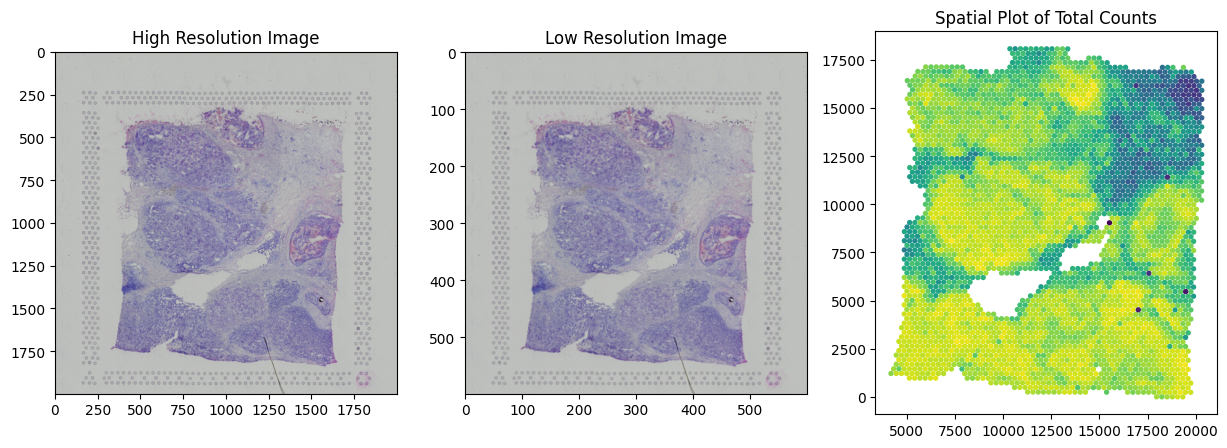

In [5]:
print(adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"].keys())
print(print(adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["metadata"]))
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(
    adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["hires"]
)
axes[0].set_title("High Resolution Image")

axes[1].set_title("Low Resolution Image")
axes[1].imshow(
    adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["lowres"]
)

axes[2].scatter(
    x=adata.obsm["spatial"][:, 0],
    y=adata.obsm["spatial"][:, 1] * -1
    - min(adata.obsm["spatial"][:, 1] * -1),  # invert y-axis
    c=adata.obs["total_counts"],
    cmap="viridis",
    s=8,
)
axes[2].set_title("Spatial Plot of Total Counts")
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")
axes[2].set_aspect("equal")


**adata.var**

Each row in adata.var corresponds to a single gene. The important columns in adata.var for this notebook include:

* `gene_ids`: The Ensembl ID for the gene.
* `feature_types`: The type of featureb entirely "Gene Expression" for this data.
* `genome`: The reference genome used.
* `n_cells`: A column added by scanpy after filtering, showing in how many spots (cells) each gene was detected.
* `total_counts`: A quality control metric showing the total number of counts for each gene across all spots.
* `mean_counts`: average expression across the data set
* `log1p_mean_counts`: log-transformed version of `mean_counts`

In [6]:
print(adata.var.shape)
adata.var.head(2)

(19690, 10)


gene_ids    feature_types  genome  n_cells  \
AL627309.1  ENSG00000238009  Gene Expression  GRCh38      118   
AP006222.2  ENSG00000286448  Gene Expression  GRCh38       15   

            n_cells_by_counts  mean_counts  log1p_mean_counts  \
AL627309.1                118     0.018013           0.017853   
AP006222.2                 15     0.002494           0.002491   

            pct_dropout_by_counts  total_counts  log1p_total_counts  
AL627309.1              96.893102     68.412788            4.240071  
AP006222.2              99.605055      9.472625            2.348765

**adata.var**

Each row in adata.obs corresponds to a observation, or spot on the tissue slide. The important columns in adata.obs for this notebook include:

* `in_tissue`: A binary column (0 or 1) indicating whether the spot is located over the actual tissue section (1) or in the background (0).
* `array_row` and `array_col`: These are the integer row and column coordinates of the spot on the physical grid of the Visium slide.
* `total_counts`: This is the total number of gene transcripts (UMIs) detected in that specific spot. It's a measure of the sequencing depth or "library size" for that spot. 
* `n_genes_by_counts`: The number of unique genes that were detected in that spot. A very low number might indicate a low-quality spot.
* `log1p_total_counts`: The log-transformed version of total_counts.

In [7]:
print(adata.obs.shape)
adata.obs.head(2)

(3798, 11)


in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               4403   
AAACACCAATAACTGC-1          1         59         19               8984   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.390268   6018.627441            8.702781   
AAACACCAATAACTGC-1                 9.103312   7362.225098            8.904253   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                    3.652838                     6.624900   
AAACACCAATAACTGC-1                    2.917385                     5.366046   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  
AAACAAGTATCTCCCA-1                    11.541192                    22.751365  
AAACACCAATAACTGC-1                     9.465522                    18.650963

Construct a graph using squidpy's 'spatial_neighbors' function which builds a graph by connecting each spot to its nearest neighbors.  The hue on the scatter plot corresponds to the total number of gene transcripts detected in each spot.

spatial_connectivities: (3798, 3798)
spatial_distances: (3798, 3798)


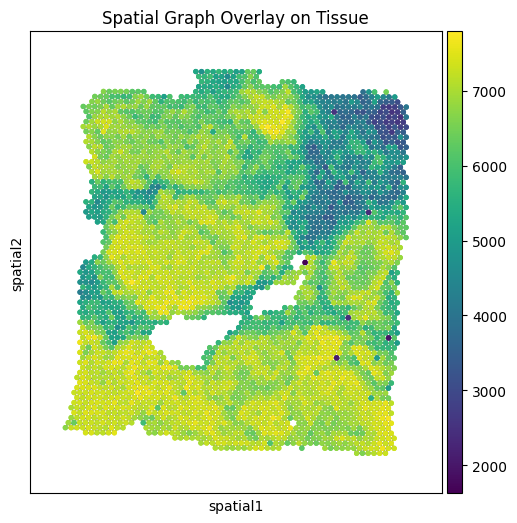

In [8]:
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
for k, v in adata.obsp.items():
    print(f"{k}: {v.shape}")

_, axes = plt.subplots(figsize=(6, 6))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",  # Use the key for the image
    color="total_counts",  # Color spots by total gene counts as an example
    shape=None,
    connectivity_key="spatial_connectivities",  # Tell squidpy to draw the graph
    title="Spatial Graph Overlay on Tissue",
    ax=axes,
)

**Observations**: 
* This slide contains 3,798 spots and 19,690 genes sampled.
* Total counts seem to correlate with cell density. The areas with the highest total_counts (the bright yellow spots) visually align with the densest, most purple regions in the H&E image. Conversely, the blue/darker areas with lower counts correspond to less dense regions (like stroma or connective tissue).
* The clear spatial pattern of high-count and low-count regions demonstrates that the tissue is heterogeneous. This heterogeneity should be leveraged by our GNN to learn if and where there are different types of genes being expressed.

---
### 4. Data Pre-processing <a class="anchor" id="model"></a>

...

Critical data for the GNN will be 
* `adata.X`: a sparse matrix that is n (number of spots) x m (number of genes) in size that contains gene expression at each spot.
* `adata.obs['spatial_connectivities']`: the graph adjacency matrix

Visualize the gene expression matrix

In [9]:
top_ten_highest_gene_idx = np.argsort(adata.X.toarray().mean(axis=0))[::-1][:20]
bottom_ten_highest_gene_idx = np.argsort(adata.X.toarray().mean(axis=0))[::-1][-20:]

In [10]:
# random_sample_of_spots = np.random.randint(0, adata.X.toarray().shape[0], 40)

# sample_array = np.concat([
#     adata.X.toarray()[random_sample_of_spots, :][:, top_ten_highest_gene_idx],
#     adata.X.toarray()[random_sample_of_spots, :][:, bottom_ten_highest_gene_idx]
# ], axis=1)

# _, axes = plt.subplots(1, 2, figsize=(20, 10))

# sns.heatmap(
#     adata.X.toarray(),
#     cmap="RdBu_r",
#     cbar_kws={"label": "Expression Level"},
#     xticklabels=[],
#     yticklabels=[],
#     cbar=False,
#     square = False,
#     ax=axes[0]
#     )

# sns.heatmap(
#     sample_array,
#     cmap="RdBu_r",
#     cbar_kws={"label": "Expression Level"},
#     xticklabels=np.concatenate([
#         adata.var_names[top_ten_highest_gene_idx],
#         adata.var_names[bottom_ten_highest_gene_idx]
#         ]),
#     yticklabels=[],
#     cbar=False,
#     square = True,
#     ax=axes[1]
#     )

# axes[0].set_title("Gene Expression Matrix")
# axes[0].set_xlabel("Genes")
# axes[0].set_ylabel("Spots")

# axes[1].set_title("Highest and Lowest Expressed Genes")
# axes[1].set_xlabel("Genes")
# axes[1].set_ylabel(f"{len(random_sample_of_spots)} Random Spots");

Some genes have relatively high expression over all spots in the slide indicated by the vertical lines in the heatmap above while others aren't expressed at all.

Convert the spatial connectivites from it's native matrix to COOrdinate sparse matrix. This format has three key components:

1. .row: A list of row indices for every non-zero element.
2. .col: A list of column indices for every non-zero element.
3. .data: A list of the actual values at those (row, col) positions

In [11]:
adata.obsp["spatial_connectivities"]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22064 stored elements and shape (3798, 3798)>

In [12]:
adata.obsp["spatial_connectivities"].tocoo()

<COOrdinate sparse matrix of dtype 'float64'
	with 22064 stored elements and shape (3798, 3798)>

In [13]:
edge_index_coo = adata.obsp["spatial_connectivities"].tocoo()
edge_index = torch.tensor(
    np.vstack([edge_index_coo.row, edge_index_coo.col]), dtype=torch.long
)

edge_index

tensor([[   0,    0,    0,  ..., 3797, 3797, 3797],
        [ 397,  487, 1087,  ..., 2399, 2614, 3563]])

In this edge_index coordinate representation, we see each node connected to at most 6 other nodes and both directions counted (i.e., node_a ==> node_b and node_b ==> node_a).

In [14]:
edges_per_node = pd.DataFrame(edge_index.flatten()).value_counts().values

edge_per_node_counts, edge_per_node_values = np.histogram(
    edges_per_node, bins=np.linspace(0, 15, 16)
)
pd.DataFrame(
    data=np.array([edge_per_node_values[:-1], edge_per_node_counts]).T,
    columns=["Number of Edges", "Counts"],
).sort_values("Counts", ascending=False).iloc[:6]

Number of Edges  Counts
12             12.0  3428.0
8               8.0   139.0
10             10.0   129.0
6               6.0    91.0
4               4.0    11.0
0               0.0     0.0

PyTorch Geometric models require a specific 'Data' object that holds the graph structure. Convert the Snapy AnnData to a compatible structure - COO (adjacency matrix) format for edges and dense torch tensor for the nodes (gene expression matrix).

In [15]:
# Edges - we will use the spatial connectivities computed by Squidpy
edge_index_coo = adata.obsp["spatial_connectivities"].tocoo()
edge_index = torch.tensor(
    np.vstack([edge_index_coo.row, edge_index_coo.col]), dtype=torch.long
)

# Nodes - we will use the gene expression matrix as node features
x = torch.tensor(adata.X.toarray(), dtype=torch.float)

# Create the PyG Data object
data = Data(x=x, edge_index=edge_index)
print("--- PyTorch Geometric Data Object ---")
print(data)

# Split edges into training, validation, and test sets
data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)

--- PyTorch Geometric Data Object ---
Data(x=[3798, 19690], edge_index=[2, 22064])


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


---
### 5. Build the Model <a class="anchor" id="model"></a>

 We will build a Graph Autoencoder (GAE). This model has two parts:

  - An Encoder: This is our GCN. Its job is to compress the high-dimensional
    gene expression of each node into a low-dimensional embedding.

  - A Decoder: It tries to reconstruct the original graph structure (the edges)
    from the learned embeddings.

The architecture of this model is based on the paper [Variational Graph Auto-Encoders](https://arxiv.org/abs/1611.07308) as we're aiming to build a model that learn meaningful latent embeddings representing our gene expressions based on their relative locations within the sample.

The encoder is comprised of Graph Convolutioanl Networks from [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907). ([blog](https://tkipf.github.io/graph-convolutional-networks/))

In [16]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        # First GCN layer: maps input features to an intermediate dimension
        self.conv1 = GCNConv(in_channels, out_channels * 2)
        # Second GCN layer: maps intermediate dimension to the final embedding dimension
        self.conv2 = GCNConv(out_channels * 2, out_channels)

    def forward(self, x, edge_index):
        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))

        # The final output is the node embedding
        x = self.conv2(x, edge_index)

        return x


class GAEModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAEModel, self).__init__()
        # The Encoder is our GCN model defined above
        self.encoder = GCNEncoder(in_channels, out_channels)

    def encode(self, x, edge_index):
        # Pass data through the encoder to get latent embeddings (z)
        return self.encoder(x, edge_index)

    def decode(self, z, pos_edge_index, neg_edge_index):
        # For a given set of positive and negative edges, predict the likelihood of existence
        # using an inner product decoder.
        pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        return pos_logits, neg_logits

    def recon_loss(self, z, pos_edge_index):
        # Sample negative edges (pairs of nodes that are not connected)
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=z.size(0),
            num_neg_samples=pos_edge_index.size(1),  # Match number of positive edges
        )

        # Get predictions (logits) for positive and negative edges
        pos_logits, neg_logits = self.decode(z, pos_edge_index, neg_edge_index)

        # Create labels: 1s for positive edges, 0s for negative edges
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        # Concatenate and compute binary cross-entropy loss
        logits = torch.cat([pos_logits, neg_logits], dim=0)
        labels = torch.cat([pos_labels, neg_labels], dim=0)

        return F.binary_cross_entropy_with_logits(logits, labels), roc_auc_score(
            labels.detach().numpy(), logits.detach().numpy()
        )

Define model parameters

In [17]:
in_channels = data.num_features  # Number of genes
out_channels = 32  # Desired size of the embedding for each spot

In [18]:
model = GAEModel(in_channels, out_channels)

# move model, data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

Train the model

In [19]:
data.to_dict().keys()

dict_keys(['x', 'val_pos_edge_index', 'test_pos_edge_index', 'train_pos_edge_index', 'train_neg_adj_mask', 'val_neg_edge_index', 'test_neg_edge_index'])

In [20]:
def train():
    """Train the model for one epoch.

    Returns:
        float: The reconstruction loss on the training edges.
    """
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    # calculate the loss on the training edges
    loss, auc_score = model.recon_loss(z, data.train_pos_edge_index)

    loss.backward()
    optimizer.step()
    return float(loss), auc_score


@torch.no_grad()
def test():
    """Evaluate the model on the validation edges.

    Args:
        pos_edge_index (torch.Tensor): The positive edge indices for validation.
    Returns:
        float: The reconstruction loss on the validation edges.
    """
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    loss, auc_score = model.recon_loss(z, data.val_pos_edge_index)

    return float(loss), auc_score


NUM_EPOCHS = 200

pbar = tqdm(range(1, NUM_EPOCHS + 1))
animation_data = []

for epoch in pbar:
    # Get embeddings for visualization
    model.eval()
    with torch.no_grad():
        full_z = model.encode(data.x, edge_index)

    train_loss, train_auc = train()
    val_loss, val_auc = test()

    animation_data.append(
        {
            "epoch": epoch,
            "val_auc": val_auc,
            "train_auc": train_auc,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "embeddings": full_z,
        }
    )

    # Update the progress bar's description with the current loss
    pbar.set_description(
        f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
    )

Epoch 012 | Train Loss: 0.7856 | Val Loss: 0.7996:   6%|▌         | 12/200 [00:01<00:24,  7.65it/s]

Epoch 200 | Train Loss: 0.5028 | Val Loss: 0.5406: 100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


**How did the model learn?**

Plot the learning objective (BCE Loss) as well as the link-prediction classification AUC to visualize how the model learned to improve performance on its specific technical task (link-prediction).

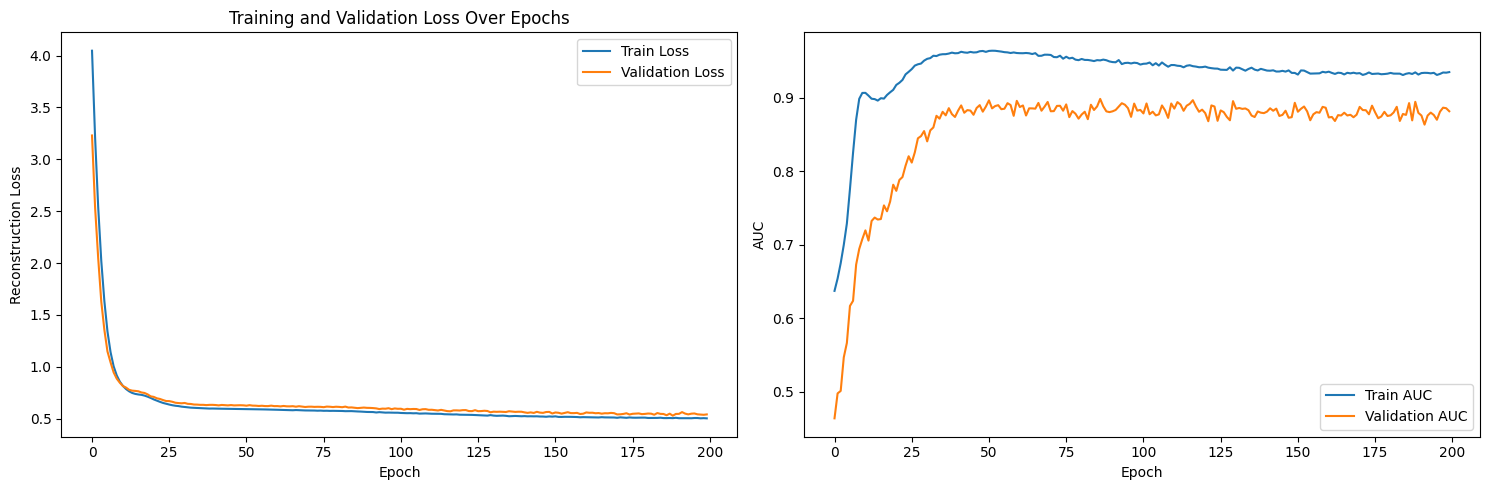

In [21]:
_, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
axes[0].plot([x["train_loss"] for x in animation_data], label="Train Loss")
axes[0].plot([x["val_loss"] for x in animation_data], label="Validation Loss")
axes[0].set_title("Training and Validation Loss Over Epochs")
axes[0].set_ylabel("Reconstruction Loss")
axes[0].legend()
axes[0].set_xlabel("Epoch")

axes[1].plot([x["train_auc"] for x in animation_data], label="Train AUC")
axes[1].plot([x["val_auc"] for x in animation_data], label="Validation AUC")
axes[1].set_ylabel("AUC")
axes[1].legend()
axes[1].set_xlabel("Epoch")
plt.tight_layout()

**Observations**:
- In simple terms, this GNN learns a spatially-aware latent representation of the gene expression. Its GCN layers are built on the principle that local neighborhoods matter, and its contrastive loss function trains it to make the embeddings of neighboring nodes similar while making the embeddings of non-neighboring nodes dissimilar

---
### 6. Clustering & Visualization <a class="anchor" id="model"></a>

##### Perform Clustering on the GCN Embeddings

Run the Leiden clustering algorithm.  The Leiden algorithm is a powerful community detection algorithm used to find groups of nodes that are more densely connected to each other than to the rest of the graph.

In [22]:
adata.obsm["GCN_embeddings"] = animation_data[-1]["embeddings"].cpu().numpy()
sc.pp.neighbors(adata, use_rep="GCN_embeddings")

sc.tl.leiden(adata, resolution=0.5, key_added="GCN_leiden_clusters")
adata.obs["GCN_leiden_clusters"].value_counts()

/var/folders/wt/5vc39b651nn6m5wm29j25dk80000gn/T/ipykernel_99252/2047042154.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added="GCN_leiden_clusters")


GCN_leiden_clusters
0     518
1     458
2     452
3     433
4     412
5     329
6     296
7     233
8     211
9     200
10    143
11    113
Name: count, dtype: int64

**What useful biological structure has the model learned?**

Plot the UMAP representation of the latent space before training and after training to visualize how the embeddings are organized after training.

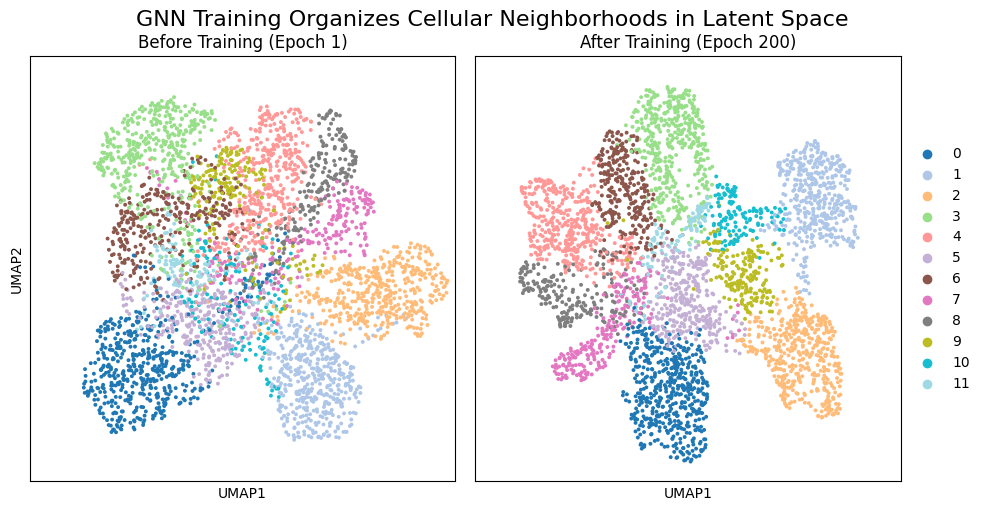

In [23]:
embeddings_before = animation_data[0]["embeddings"].cpu().numpy()
embeddings_after = animation_data[-1]["embeddings"].cpu().numpy()

scaler = StandardScaler()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Store the "before" embeddings in adata.obsm
adata.obsm["GCN_before_training"] = embeddings_before
# Compute neighbors and UMAP based on these UNTRAINED embeddings
sc.pp.neighbors(adata, use_rep="GCN_before_training")
sc.tl.umap(adata, min_dist=0.5, random_state=42)

adata.obsm["X_umap"] = scaler.fit_transform(adata.obsm["X_umap"])

# Plot the result, but COLOR by the FINAL cluster assignments
sc.pl.umap(
    adata,
    color="GCN_leiden_clusters",  # Use final clusters for coloring
    ax=axes[0],
    show=False,
    title="Before Training (Epoch 1)",
    palette="tab20",
    legend_loc=None,
)

# Store the "after" embeddings in adata.obsm
adata.obsm["GCN_after_training"] = embeddings_after
# Re-compute neighbors and UMAP based on the TRAINED embeddings
sc.pp.neighbors(adata, use_rep="GCN_after_training")
sc.tl.umap(adata, min_dist=0.5, random_state=42)

adata.obsm["X_umap"] = scaler.fit_transform(adata.obsm["X_umap"])

sc.pl.umap(
    adata,
    color="GCN_leiden_clusters",
    ax=axes[1],
    show=False,
    title=f"After Training (Epoch {animation_data[-1]['epoch']})",
    palette="tab20",
)

axes[0].set_aspect("equal", adjustable="box")
axes[0].set_xlim([-2.5, 2.5])
axes[0].set_ylim([-2.5, 2.5])

axes[1].set_aspect("equal", adjustable="box")
axes[1].set_ylabel("")
axes[1].set_xlim([-2.5, 2.5])
axes[1].set_ylim([-2.5, 2.5])

fig.suptitle(
    "GNN Training Organizes Cellular Neighborhoods in Latent Space", fontsize=16
)
plt.tight_layout()

##### Visualize the Cellular Neighborhoods

Use squidpy's plotting function to color each spot on the tissue image according to its assigned cluster ID. This reveals the spatial organization of the cellular neighborhoods identified by the GNN. In the same pannel, use UMAP to visualize how the embeddings cluster in 2D space colored by their Leiden assignments.

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


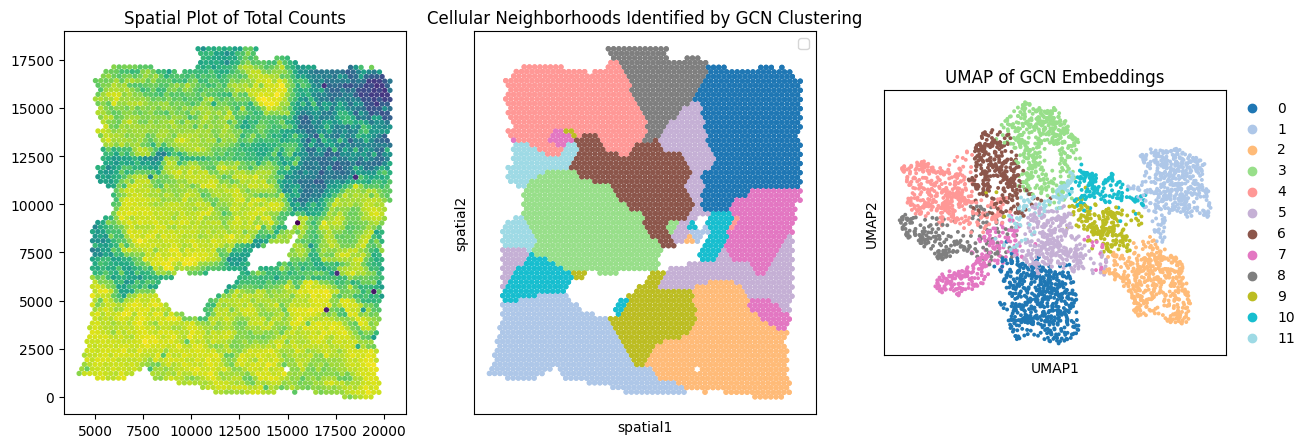

In [24]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(
    x=adata.obsm["spatial"][:, 0],
    y=adata.obsm["spatial"][:, 1] * -1
    - min(adata.obsm["spatial"][:, 1] * -1),  # invert y-axis
    c=adata.obs["total_counts"],
    cmap="viridis",
    s=8,
)
axes[0].set_title("Spatial Plot of Total Counts")
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")
axes[2].set_aspect("equal")

sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color="GCN_leiden_clusters",
    shape=None,
    title="Cellular Neighborhoods Identified by GCN Clustering",
    ax=axes[1],
)
axes[1].legend([])
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(
    adata, color="GCN_leiden_clusters", title="UMAP of GCN Embeddings", ax=axes[2]
)

Identify the genes that are most significantly up-regulated in each cluster using a t-test to find differentially expressed genes.

In [25]:
sc.tl.rank_genes_groups(
    adata, groupby="GCN_leiden_clusters", method="t-test", key_added="marker_genes"
)

# Visualize top marker genes for each cluster
pd.DataFrame(adata.uns["marker_genes"]["names"]).head(5)

0        1        2      3          4      5          6         7  \
0  MALAT1   CXCL14   CRISP3   CPB1      COX6C   CD74    SLC39A6       MGP   
1      C3    CCND1  SLITRK6    CFB    SLC39A6     C3  LINC00645  SERPINA3   
2   TIMP1    GFRA1  S100A13  HLA-B       SNCG  IGLC2      PVALB       DSP   
3     MGP  S100A11   IGFBP5  H2AFJ  RAB11FIP1  IGHG1      EXOC2      TFF1   
4   RPL36     GNG5   SERHL2  HLA-C      WFDC2   IGKC     ZNF703    ACADSB   

       8      9      10     11  
0    MGP  HLA-B  CXCL14   APOE  
1    ALB  HLA-A   IGLC2   CD74  
2  S100G   IFI6   RPL36   C1QA  
3  IFI27  IFI27   IGHG3  APOC1  
4   CSTA  S100G   RPL13  HLA-E

Create a dot plot of the top 4 marker genes for each cluster

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:138: UserWarning: You’re trying to run this on 19690 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)


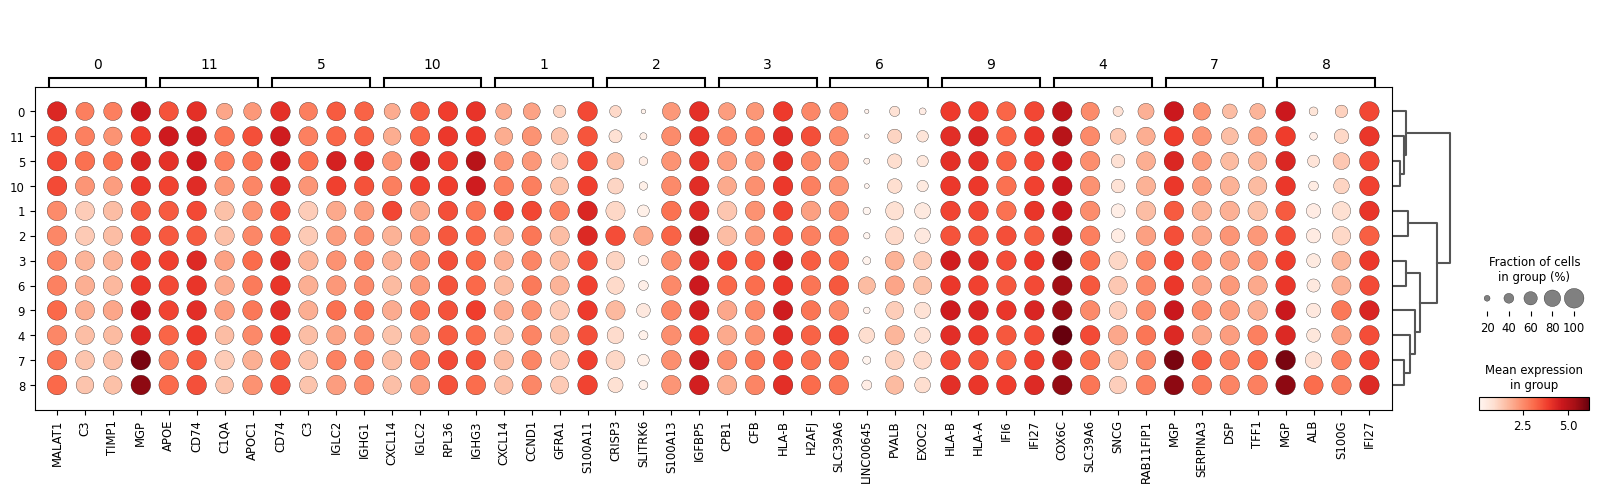

In [26]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=4, key="marker_genes", groupby="GCN_leiden_clusters"
)

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


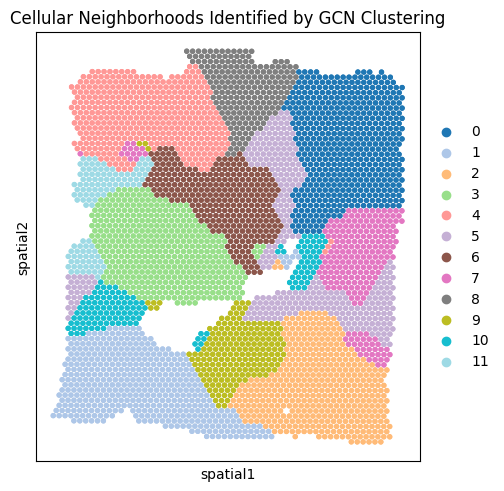

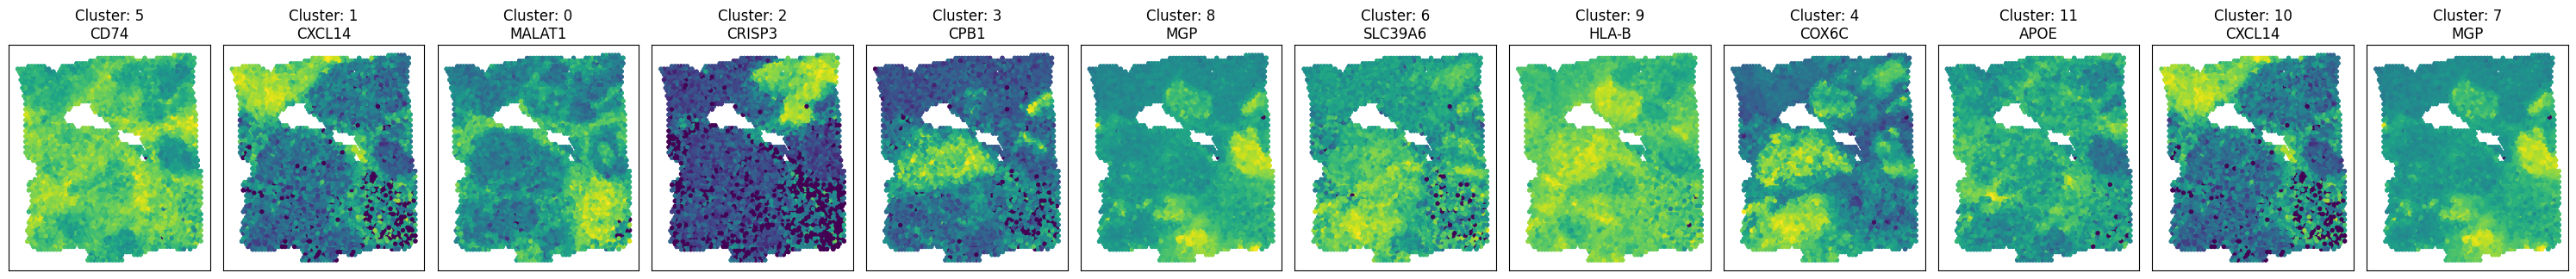

In [27]:
clusters = adata.obs["GCN_leiden_clusters"].unique()
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color="GCN_leiden_clusters",
    shape=None,
    title="Cellular Neighborhoods Identified by GCN Clustering",
)

_, axes = plt.subplots(1, len(clusters), figsize=(30, 5), sharey=True)
for idx, cluster in enumerate(clusters):
    top_marker_gene_for_cluster_2 = adata.uns["marker_genes"]["names"][cluster][0]

    axes[idx].set_title(
        f"Cluster {cluster} - Top Marker Gene: {top_marker_gene_for_cluster_2}"
    )
    sq.pl.spatial_scatter(
        adata,
        library_id="spatial",
        color=top_marker_gene_for_cluster_2,
        shape=None,
        title=f"Cluster: {cluster}\n{top_marker_gene_for_cluster_2}",
        ax=axes[idx],
        colorbar=False,
    )
    axes[idx].invert_yaxis()
    
    axes[idx].set_ylabel("")
    axes[idx].set_xlabel("")
    axes[idx].set_aspect("equal")

plt.tight_layout()

**Observations**
* The GNN successfully segmented the tissue into distinct, spatially coherent clusters that correspond to real, localized biological niches each defined by a unique top gene.

* The embeddings are high-quality - well-separated in the latent space meaning the GCN learned distinct feature representations for each neighborhood.

* The clusters correspond to biological effects based on the fact that the GCN Clusters appear in similar locations to the features in the Total Counts plot as well as regions of localized gene expression. Key Takeaways:

  * **Cluster 0 and 8**: These clusters are defined by an adaptive immune response since CD74 is essential for antigen presentation and IGLC2 is an immunoglobulin. These pinpoint regions dense with B-cells and plasma cells possibly forming an organized structure to fight the tumor. 

  * **Cluster 1**: This cluster possibly represents an highly proliferative and aggressive cancer region given that MALAT1 is suspected to be associated with metastasis.


In [28]:
# Use the embeddings from the final epoch
final_embeddings = animation_data[-1]["embeddings"]
adata.obsm["GCN_final_embeddings"] = final_embeddings.cpu().numpy()


# Define a 2x3 grid for the plots
fig = plt.figure(figsize=(24, 8))
gs = GridSpec(2, 3, figure=fig)

# Define the axes for each plot
ax_loss = fig.add_subplot(gs[0, 0])
ax_auc = fig.add_subplot(gs[1, 0])
ax_spatial = fig.add_subplot(gs[:, 1])
ax_umap = fig.add_subplot(gs[:, 2])

# Extract lists of metrics for plotting
epochs = [d["epoch"] for d in animation_data]
train_losses = [d["train_loss"] for d in animation_data]
val_losses = [d["val_loss"] for d in animation_data]
train_aucs = [d["train_auc"] for d in animation_data]
val_aucs = [d["val_auc"] for d in animation_data]


# This function is called for each frame of the animation
def update(frame):
    # Clear all axes for the new frame
    ax_loss.clear()
    ax_auc.clear()
    ax_spatial.clear()
    ax_umap.clear()

    # Get data for the current frame
    epoch_data = animation_data[frame]
    current_epoch = epoch_data["epoch"]
    current_train_loss = epoch_data["train_loss"]
    current_val_loss = epoch_data["val_loss"]
    current_train_auc = epoch_data["train_auc"]
    current_val_auc = epoch_data["val_auc"]
    embeddings_data = epoch_data["embeddings"].cpu().numpy()

    # --- Plot 1: Training & Validation Loss ---
    ax_loss.plot(
        epochs[: frame + 1],
        train_losses[: frame + 1],
        marker=".",
        linestyle="-",
        color="b",
        alpha=0.75,
        label="Train Loss",
    )
    ax_loss.plot(
        epochs[: frame + 1],
        val_losses[: frame + 1],
        marker=".",
        linestyle="-",
        color="k",
        alpha=0.75,
        label="Validation Loss",
    )
    ax_loss.set_xlim(0, epochs[-1])
    ax_loss.set_ylim(bottom=0.4)
    ax_loss.set_title(f"Loss at Epoch {current_epoch}")
    ax_loss.set_ylabel("BCE Loss")
    ax_loss.grid(True)
    ax_loss.legend()

    # --- Plot 2: Training & Validation AUC ---
    ax_auc.plot(
        epochs[: frame + 1],
        train_aucs[: frame + 1],
        marker=".",
        linestyle="-",
        color="b",
        alpha=0.75,
        label="Train AUC",
    )
    ax_auc.plot(
        epochs[: frame + 1],
        val_aucs[: frame + 1],
        marker=".",
        linestyle="-",
        color="k",
        alpha=0.75,
        label="Validation AUC",
    )
    ax_auc.set_xlim(0, epochs[-1])
    ax_auc.set_ylim(0.4, 1.0)
    ax_auc.set_title(f"AUC at Epoch {current_epoch}")
    ax_auc.set_xlabel("Epoch")
    ax_auc.set_ylabel("Link Prediction AUC")
    ax_auc.grid(True)
    ax_auc.legend()

    adata.obsm["GCN_temp_embeddings"] = embeddings_data

    sc.pp.neighbors(adata, use_rep="GCN_temp_embeddings", key_added="temp_neighbors")
    # We re-run Leiden here just for the spatial plot coloring, using the same key
    sc.tl.leiden(
        adata,
        resolution=0.5,
        key_added="GCN_temp_clusters_anim",
        random_state=42,
        neighbors_key="temp_neighbors",
    )

    sq.pl.spatial_scatter(
        adata,
        color="GCN_leiden_clusters",
        ax=ax_spatial,
        shape=None,
        title=None,
        legend_loc=None,
    )
    ax_spatial.set_title("Spatial Neighborhoods")
    ax_spatial.invert_yaxis()
    ax_spatial.set_aspect("equal", adjustable="box")

    sc.tl.umap(adata, min_dist=0.5, random_state=42, neighbors_key="temp_neighbors")
    sc.pl.umap(
        adata,
        color="GCN_leiden_clusters",  # Use the final clusters for consistent coloring
        ax=ax_umap,
        show=False,
        title=None,
        legend_loc=None,
    )
    ax_umap.set_title("UMAP of Embeddings")
    ax_umap.set_aspect("equal", adjustable="box")

    fig.suptitle(f"GCN Training Convergence at Epoch {current_epoch}", fontsize=16)


# Create the animation object
ani = FuncAnimation(
    fig, update, frames=len(animation_data), interval=500, repeat=False
)

# Display the animation in the notebook
HTML(ani.to_html5_video())

IMG_DIR = os.path.join("..", "imgs", "spatial_transciptiomics")
os.makedirs(IMG_DIR, exist_ok=True)
ani.save(
    os.path.join(IMG_DIR, "gcn_training_convergence.mp4"), writer="ffmpeg", dpi=100
)


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


---
### 6. Summary

...

The primary findings include:
* ...

Next Steps:
* Investigate the effect of different model architectures on the results. How do deeper networks affect the embeddings?